# Exploration in accuracy of image models and model interpretability based on XGBoosting and effect of PCA components

### Datasource: https://cs.nyu.edu/~roweis/data.html  
- The “target” for this database is an integer from 0 to 39 indicating the identity of the person pictured;
- In the dataset, there are images of 40 people with 10 different poses e.g. smiling and angry faces etc. Therefore, there are total 400 samples.  
- The images size is (64, 64), which is stored as features of size 4096

### Goal & Motivation:  

-  XGBoost is an algorithm that has recently been dominating applied machine learning for structured or tabular data.  
  <font color='red'>However</font>, XGBoost could not work well on all of the datasets and it is hard to tell why the model could not perform well and what the important features have been neglected or what wrong features have been overestimated by the model.   
  Thus, this article will explore:  
   - How will the XGBoost models perform on faces classification and explained by interpretability?
   - How could the number of PCA components affect the interpretable results?
   - How does interpretability work for directing hyperparameters/features tuning?  
   
__3 levels will be explored:__    
__1. Model level:__  
   - For optimizing XGM model by exploring interpretability of important features of faces data.  

__2. PCA level:__    
   - For the trade-off of accuracy VS wall time , find out the best number of components of PCA for this case with quantitative measures and human intervention.  

__3. Relation:__  
   - Explore how the classification/prediction will be affected by XGB models with different PCA components.  
   - <font color='red'>Explore the error by interpretability:</font>   
        - Why these images were always wrongly predicted?   
        - What the different features between these wrongly predicted images. (These images were always wrongly predicted by training couple of XGM models with different number of PCA componenents.)  

### Steps and Structure:
<img src='Image/Archi3.png'>

#### Comparison:  
<img src='Image/Comparison3.png'>

## 1 prerequisite and Data processing 

### 1.0 Some Variable for storing results:

In [1]:
list_pca_wrong_prediction_count = [] # Store the tuples: number of wrong predicted results with different PCA.
list_pca_number_wrongPredictionLocation = [] # Store the tuples: (number of PCA components, wrong Predictions locations).
list_pca_wrongPrediction_intersection = [] # Store the intersection of results different number of component in PCA.
list_pipeline_RF = [] #Store the pipeline with different number of components into list for iteration.

### 1.1 Import lib:

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
from skimage.util import montage # to make a nice montage of the images
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA # contains a randomized method to approximate the first $N$ principal components much more quickly than the standard PCA estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000)

In [3]:
%load_ext autoreload
%autoreload 2 # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

from lime.wrappers.scikit_image import SegmentationAlgorithm

### 1.2 Import face dataset:

In [4]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

In [5]:
faces.data.shape

(400, 4096)

In [6]:
len(faces.images) # 400 images

400

__Note__:  
-  If (1797, 64) is the shape, means they are 64-dimensional.   
- In this case, should be 4096(64*64) dimensional for each image.

### 1.3 Reshape X_vec and Get Target y_vec:

- Next, will make each image color so lime_image works correctly:
 - __X_vec:__
    - 1. Reshape the every face in dataset to be new-sized: (-1, 64, 64)
    - 2. Stack the new-sized matrix along with vertical axis- by numpy.stack(, axis=0)
    - 3. Color the gray image for LIME explanation correctly.
 - __y_vec:__
    - 1. target of face: Labels associated to each face image. Those labels are ranging from 0-39 and correspond to the Subject IDs.

In [7]:
X_vec = np.stack([gray2rgb(img) for img in faces.data.reshape((-1,64,64))],axis=0)
y_vec = faces.target.astype(np.uint8)

In [8]:
print(X_vec.shape)
print(X_vec[:,:,:,0].shape)

(400, 64, 64, 3)
(400, 64, 64)


In [9]:
y_vec

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

- Note:  
'-1': what it does is the notation for unknown dimension, meaning: let numpy fill the missing dimension with the correct value so my array remain with the same number of items.  
    - e.g.: x = x.reshape((10, 1000))=>x = x.reshape((10, -1)) or x = x.reshape((-1, 1000))   

### 1.4 Plot images and define plot function:

(-0.5, 1279.5, 1279.5, -0.5)

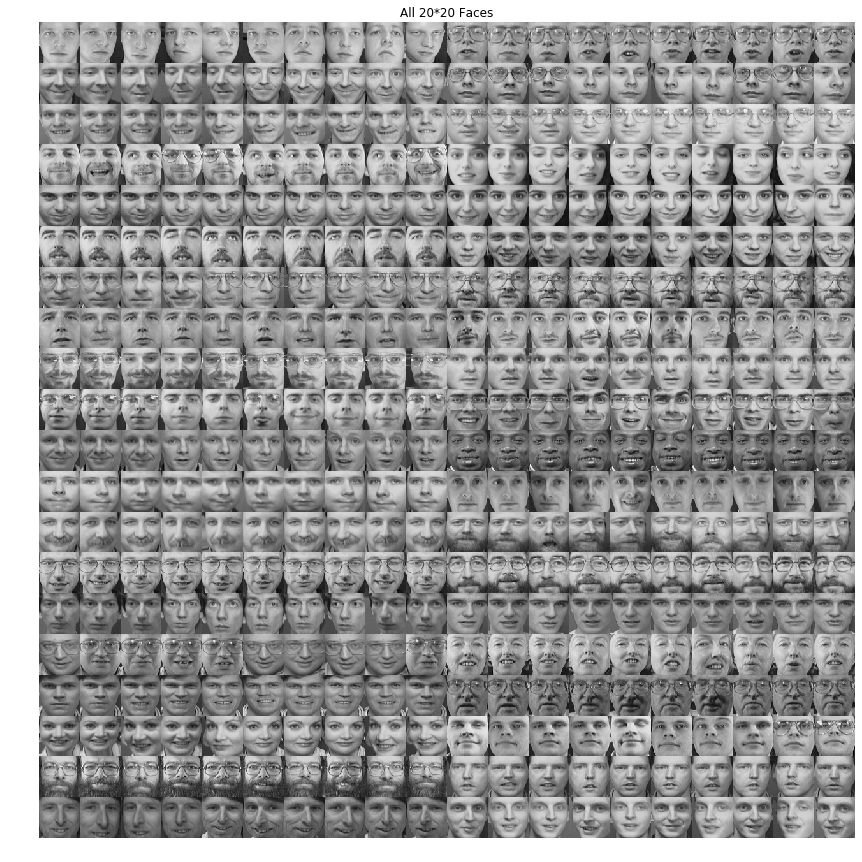

In [10]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize = (15,15))
ax1.imshow(montage(X_vec[:,:,:,0]),cmap='gray') 
# Note: must by X_vec[:,:,:,0] not X_vec[:,:,:,3]
# Otherwise: index 3 will be out of bounds for axis 3 with size 3

ax1.set_title('All 20*20 Faces')
ax1.axis('off')

In [11]:
# function for plotting images:
# This function is for the purpose of plotting with specific images num, by rows*cols specified.
def plot_images(images, title, total_images, rows):
    fig= plt.figure(figsize = (12,12)) # create a new figure window
    
    fig.suptitle(title)
    for i in range(total_images): # display specific images (eg.:20)
        # subplot : e.g.:4 rows and 5 columns
        img_grid = fig.add_subplot(rows, int(round(total_images/rows)), i+1)
        
        # plot features as image
        img_grid.imshow(images[i], cmap='gray')

In [12]:
#plot_images(faces.images, 'test', 24, 6)

__Note__:  
   - Montage: https://scikit-image.org/docs/0.7.0/api/skimage.util.montage.html

### 1.5 Split the data:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.70)

c:\python37\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## 2. Setup a Pipeline for processing the images

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

In [15]:
class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

### 2.1 Turn Gray for each image:

In [16]:
step_turnGray = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])

### 2.2 Flatten the image back to 1d vectors:

- image.ravel(): Return a contiguous flattened array (A 1-D array, containing the elements of the input, is returned.)

In [17]:
step_flatten = PipeStep(lambda img_list:[img.ravel() for img in img_list])

### 2.3 Choosing the number of components for PCA:    
- __PCA(principal component analysis)__:  
    - __What__:  
    one of the algorithms for dimensionality reduction: For dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.  
    - __Why__:  
    - This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.
    - __How__:  
        - In PCA, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset.
    The projection of each data point onto the principal axes are the "principal components" of the data: The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.  
        - A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.  
        - The fit learns some quantities from the data, most importantly the "components" and "explained variance":  
            - <font color='red'>"__components__"</font> to define the <font color='red'>direction</font> of the vector.  
            - <font color='red'>"__explained variance__"</font> to define the <font color='red'>squared-length</font> of the vector.
            - These vectors represent the principal axes of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data (more precisely, it is a measure of the variance of the data when projected onto that axis.)
    - __Copmare with pixel basis dimension reduction__:  
        - Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean plus some components.

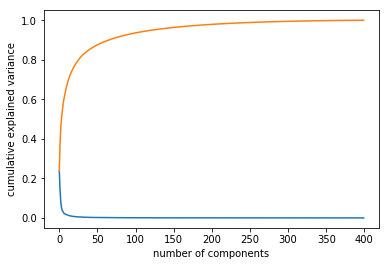

In [18]:
pca = PCA().fit(faces.data)
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

__Note__:  
- We are able to explain more than 60% variance in the dataset using just around 10 components.  
- This curve quantifies how much of the total, 400-dimensional variance is contained within the first N components.
    - <font color='blue'>Blue line</font> represents component-wise explained variance;   
    - <font color='orange'>orange line</font> represents the cumulative explained variance.    
    For example, we see that with the digits the first 40 components contain approximately 75% of the variance, while you need around 300 components to describe close to 100% of the variance.

Here we see that our 25(perhaps)-dimensional projection loses a lot of information (as measured by the explained variance) and that we need about 100 components to retain 90% of the variance.  

- Therefore, in next sections will compare with 4 'number of components' for further fit and interpretability to figure out how the 'number of component' affects the result and interpretability:
    - __Part 1__: 'number of component' == 5: 0.6;  
    - __Part 2__: 'number of component' == 10 : 0.7;  
    - __Part 3__: 'number of component' == 50 : 0.85; 
    - __Part 4__: 'number of component' == 100 : 0.9; 
    - __Part 5__: 'number of component' == 250 : 0.95; 
    - __Part 6__: 'number of component' == 280 : 0.99; 

## 3. Make a pipeline to include all steps:

__Pipelines__:  
- It is a way to streamline a lot of the routine processes, encapsulating little pieces of logic into one function call, which makes it easier to actually do modeling instead just writing a bunch of code.   
-  Pipelines are set up with the fit/transform/predict functionality.  
- It provides a way to take code, fit it to the training data, apply it to the test data without having to copy and paste everything.

- __Pipeline functions:__
    - fit() to fit to training data;
    - transform() to apply it to training data;
    - fit_transform() to do both.

__PCA(Principal Component Analysis)__:  
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
   - PCA is very useful for reducing many dimensions into a smaller set of dimensions, as humans can not visualize data on more than 3 dimensions it is usually helpful to reduce multidimensional datasets into 2 or 3 dimensions and graph them in order to get a better understanding of the data.  
   - In this case, we reduced from 10304 dimension to 25-dimensional: we have found the optimal stretch and rotation in 10304-dimensional space that allows us to see the layout of the digits in 25 dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.  
   i.e.: 
   __x=[x1,x2,x3⋯x10304] to image(x)=x1⋅(pixel 1)+x2⋅(pixel 2)+x3⋅(pixel 3)⋯x10304⋅(pixel 10304)__

### <font color = 'red'>3.1 __Part 1: 'number of component' == 5: 0.6__</font>

In [19]:
%%time
pipeline_RF_5 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(n_components=5)), # project from 4096 to 5 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

Wall time: 0 ns


In [20]:
%%time
pipeline_RF_5.fit(X_train, y_train)

Wall time: 3.02 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x0000027767ACA2B0>), ('Flatten images', <__main__.PipeStep object at 0x0000027767ACA438>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [21]:
list_pipeline_RF.append(tuple(('pipeline_RF_5', pipeline_RF_5)))

### <font color = 'red'> __3.2 Part 2: 'number of component' == 10: 0.7__</font>

In [22]:
pipeline_RF_10 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(10)), # # project from 4096 to 10 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

In [23]:
%%time
pipeline_RF_10.fit(X_train, y_train)

Wall time: 2.84 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x0000027767ACA2B0>), ('Flatten images', <__main__.PipeStep object at 0x0000027767ACA438>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0....    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [24]:
list_pipeline_RF.append(tuple(('pipeline_RF_10',pipeline_RF_10)))

### <font color = 'red'> 3.3 __Part 3: 'number of component' == 50: 0.85__</font>

In [25]:
pipeline_RF_50 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(50)), # # project from 4096 to 50 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

In [26]:
%%time
pipeline_RF_50.fit(X_train, y_train)

Wall time: 4.81 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x0000027767ACA2B0>), ('Flatten images', <__main__.PipeStep object at 0x0000027767ACA438>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0....    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [27]:
list_pipeline_RF.append(tuple(('pipeline_RF_50',pipeline_RF_50)))

### <font color = 'red'> __3.4 Part 4: 'number of component' == 100: 0.90__</font>

In [28]:
pipeline_RF_100 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(100)), # # project from 4096 to 100 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

In [29]:
%%time
pipeline_RF_100.fit(X_train, y_train)

Wall time: 5.89 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x0000027767ACA2B0>), ('Flatten images', <__main__.PipeStep object at 0x0000027767ACA438>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [30]:
list_pipeline_RF.append(tuple(('pipeline_RF_100',pipeline_RF_100)))

### <font color = 'red'> __3.5 Part 5: 'number of component' == 250: 0.95__</font>

In [31]:
pipeline_RF_250 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(250)), # # project from 4096 to 250 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

In [32]:
%%time
pipeline_RF_250.fit(X_train, y_train)

Wall time: 11 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x0000027767ACA2B0>), ('Flatten images', <__main__.PipeStep object at 0x0000027767ACA438>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=250, random_state=None,
  svd_solver='auto', tol=0...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [33]:
list_pipeline_RF.append(tuple(('pipeline_RF_250',pipeline_RF_250)))

### <font color = 'red'> __3.6 Part 6: 'number of component' == 280: 0.99__</font>  
- min(n_samples, n_features)=280

In [34]:
pipeline_RF_280 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(280)), # # project from 4096 to 280 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

In [35]:
%%time
pipeline_RF_280.fit(X_train, y_train)

Wall time: 14.4 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x0000027767ACA2B0>), ('Flatten images', <__main__.PipeStep object at 0x0000027767ACA438>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=280, random_state=None,
  svd_solver='auto', tol=0...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [36]:
list_pipeline_RF.append(tuple(('pipeline_RF_280',pipeline_RF_280)))

__Note__:  
  - __Normalization:__   
    - Numbers closer together (in the sense of continuous space with a linear scale) are also more likely to produce a smoother optimization path.
    - Steps:  
       - 1. Computing a mean and standard deviation of the images
       - 2. (from all images) we subtract the mean and divide by the standard deviation.  
    - Tips:  
       - Optimization must come from the training dataset itself, and must not be computed over the entire dataset including the validation/test datasets. This is because that information should not be passed to the model in any way - it is kind of cheating.

## 4. Scoring the Models:

In [37]:
from sklearn.metrics import classification_report

### 4.0 Define function to get the list with location of wrong prediction:

In [38]:
def wrong_detected(pca_pipe, pca_num, rangeOfpredictedImage):
    list_wrong = []

    for i in range (rangeOfpredictedImage):
        # if images are not same then print location of images
        if y_test[i] != pca_pipe[i]:
            list_wrong.append(i)
            
    list_pca_wrong_prediction_count.append((pca_num,len(list_wrong))) #Store the number of wrong prediction into list.
    list_pca_number_wrongPredictionLocation.append((pca_num,list_wrong)) 
    
    print('Wrongly detected image-locations:', list_wrong)
    print('Total:', len(list_wrong))
    return list_wrong

### Define function to plot faces in test set and predicted set.

In [39]:
def compare_test_predicted(images, firstNImages, rows, test_targets, prediction_test_targets):
    # store test images in list
    faces_test = []
    for i in test_targets:
        faces_test.append(images[i])

    # store predicted images in list
    faces_predict = []
    for i in prediction_test_targets:
        faces_predict.append(images[i])

    # plot the first 20 images from the list
    plot_images(faces_test, 'faces_test', firstNImages, rows) #plot_images(faces.images, 'test', 24, 6)
    plot_images(faces_predict, 'faces_predict', firstNImages, rows)  # plot_images(faces.images, 'test', 24, 6)
    plt.show()
    
    return faces_test

## 4.1 Predict based on pipeline, and evaluate the model:

In [40]:
print('X_traint.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_traint.shape:  (280, 64, 64, 3)
y_train.shape:  (280,)
X_test.shape:  (120, 64, 64, 3)
y_test.shape:  (120,)


### <font color = 'red'> __4.1.1 Part 1: 'number of component' == 5: 0.6__</font>

In [41]:
# compute on remaining test data, predict the 'target' for 'test data'
pipe_pred_test_5 = pipeline_RF_5.predict(X_test)
pipe_pred_prop_5 = pipeline_RF_5.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.25      0.50      0.33         2
           2       0.00      0.00      0.00         2
           3       0.08      0.33      0.13         3
           4       0.14      1.00      0.25         1
           5       0.60      1.00      0.75         3
           6       0.00      0.00      0.00         3
           7       1.00      0.33      0.50         3
           8       0.50      0.67      0.57         3
           9       0.50      0.33      0.40         3
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         1
          14       0.50      0.33      0.40         3
          15       0.00      0.00      0.00         5
          16       0.67      0.50      0.57         4
          17       0.00    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 4.1.2 Get the wrong prediction based on this model:

- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 1, 2, 3, 4, 5, 6, 7 etc.are at error.

In [42]:
list_pca_5_wrongList = wrong_detected(pipe_pred_test_5, 5, 120)
print('\n')
for wrongLocation in list_pca_5_wrongList:
    print('Using #{} where the label was {} predicted {}'.format(wrongLocation, y_test[wrongLocation], pipe_pred_test_5[wrongLocation]))

Wrongly detected image-locations: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 29, 30, 33, 34, 35, 37, 38, 39, 41, 42, 44, 45, 46, 48, 49, 52, 55, 56, 58, 59, 60, 61, 63, 64, 65, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 88, 89, 91, 92, 95, 96, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 111, 113, 115, 116, 118, 119]
Total: 83


Using #0 where the label was 33 predicted 3
Using #1 where the label was 14 predicted 19
Using #2 where the label was 12 predicted 19
Using #3 where the label was 35 predicted 23
Using #4 where the label was 12 predicted 20
Using #5 where the label was 38 predicted 29
Using #6 where the label was 35 predicted 6
Using #7 where the label was 6 predicted 3
Using #8 where the label was 24 predicted 17
Using #11 where the label was 24 predicted 3
Using #13 where the label was 15 predicted 28
Using #15 where the label was 22 predicted 2
Using #16 where the label was 6 predicted 18
Using #17 where the label was 34 

### 4.1.3 Pick some faces in test set & predicted set to check wrong prediction.

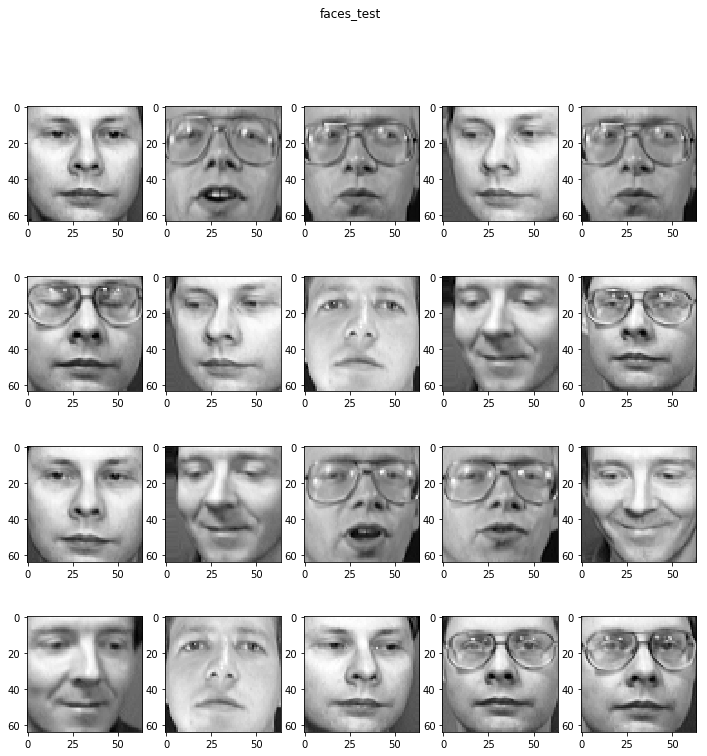

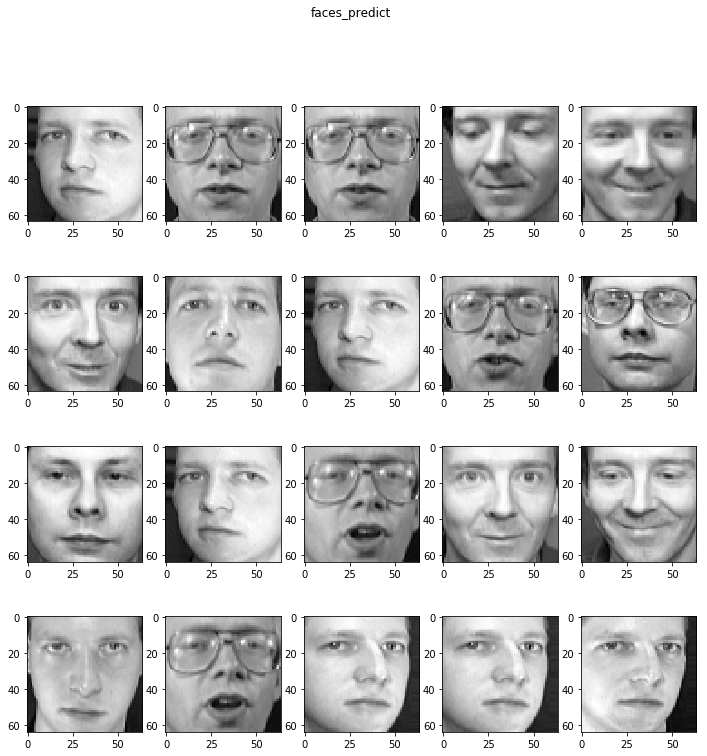

In [43]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_5 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_5)

#### Conclusion for PCA(5):
69 wrongly predicted images. Micro Avg is 0.42.

### <font color = 'red'> __4.2 Part 2: 'number of component' == 10: 0.7__</font>

In [44]:
# compute on remaining test data
pipe_pred_test_10 = pipeline_RF_10.predict(X_test)
pipe_pred_prop_10 = pipeline_RF_10.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_10))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         2
           3       0.17      0.33      0.22         3
           4       0.00      0.00      0.00         1
           5       0.67      0.67      0.67         3
           6       0.20      0.33      0.25         3
           7       0.67      0.67      0.67         3
           8       0.50      1.00      0.67         3
           9       0.50      0.33      0.40         3
          10       0.50      0.25      0.33         4
          11       0.80      0.67      0.73         6
          12       0.00      0.00      0.00         5
          13       1.00      1.00      1.00         1
          14       0.75      1.00      0.86         3
          15       1.00      0.20      0.33         5
          16       0.30      0.75      0.43         4
          17       0.00    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 4.2.3 Pick some faces in test set & predicted set to check wrong prediction.

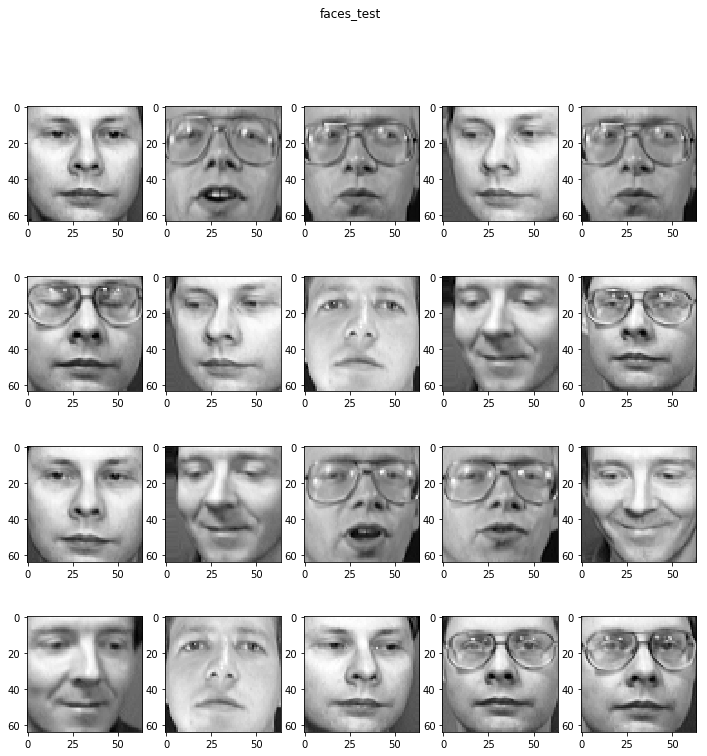

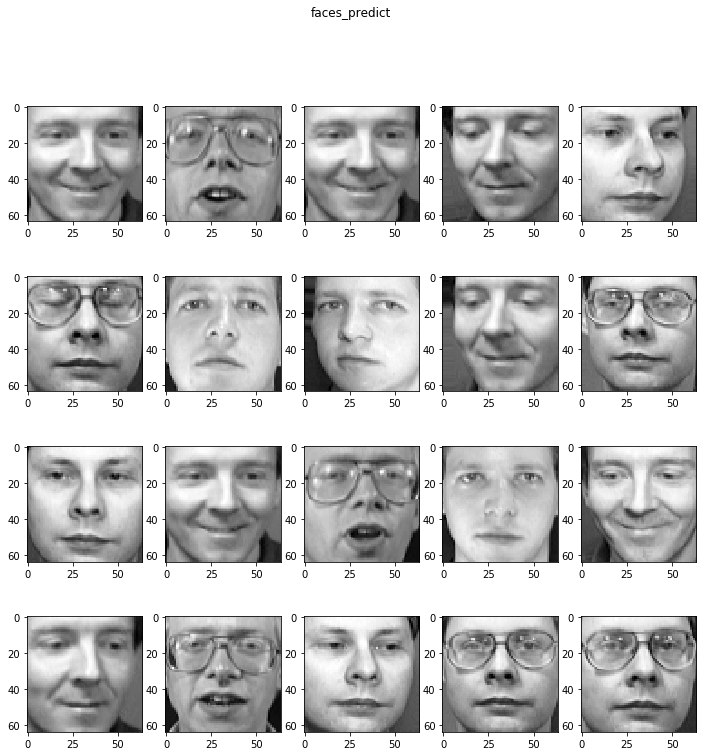

In [45]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_10 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_10)

- Check all the wrong predicted result and actual label:

In [47]:
list_pca_10_wrongList = wrong_detected(pipe_pred_test_10, 10, 120)

for wrongLocation in list_pca_10_wrongList:
    print('Using #{} where the label was {} predicted {}'.format(wrongLocation, y_test[wrongLocation], pipe_pred_test_10[wrongLocation]))

Wrongly detected image-locations: [0, 2, 3, 4, 6, 7, 11, 13, 16, 20, 21, 23, 24, 29, 30, 33, 38, 39, 41, 42, 44, 48, 49, 56, 58, 59, 60, 62, 63, 64, 65, 68, 69, 72, 74, 75, 76, 77, 80, 81, 84, 95, 96, 99, 100, 101, 104, 105, 106, 107, 108, 109, 113, 115, 116, 117, 118, 119]
Total: 58
Using #0 where the label was 33 predicted 20
Using #2 where the label was 12 predicted 20
Using #3 where the label was 35 predicted 23
Using #4 where the label was 12 predicted 39
Using #6 where the label was 35 predicted 6
Using #7 where the label was 6 predicted 3
Using #11 where the label was 24 predicted 20
Using #13 where the label was 15 predicted 0
Using #16 where the label was 6 predicted 16
Using #20 where the label was 24 predicted 12
Using #21 where the label was 37 predicted 20
Using #23 where the label was 22 predicted 8
Using #24 where the label was 5 predicted 20
Using #29 where the label was 12 predicted 20
Using #30 where the label was 27 predicted 10
Using #33 where the label was 39 predi

#### Conclusion for PCA(10):
54 wrongly predicted images.

### <font color = 'red'> __4.3 Part 3: 'number of component' == 50: 0.85__</font>

### 4.3.1 Predict based on pipeline, and evaluate the model:

In [48]:
pipe_pred_test_50 = pipeline_RF_50.predict(X_test)
pipe_pred_prop_50 = pipeline_RF_50.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_50))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.50      0.40         2
           2       0.00      0.00      0.00         2
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         1
           5       0.50      1.00      0.67         3
           6       0.50      0.33      0.40         3
           7       0.75      1.00      0.86         3
           8       0.33      0.33      0.33         3
           9       1.00      0.33      0.50         3
          10       1.00      0.50      0.67         4
          11       1.00      0.50      0.67         6
          12       0.33      0.20      0.25         5
          13       1.00      1.00      1.00         1
          14       0.50      0.33      0.40         3
          15       0.60      0.60      0.60         5
          16       1.00      0.50      0.67         4
          17       0.00    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 4.3.2 Get the wrong prediction based on this model:

In [49]:
wrong_detected(pipe_pred_test_50, 50, 120)

Wrongly detected image-locations: [0, 1, 2, 3, 4, 6, 7, 8, 12, 13, 16, 18, 19, 20, 21, 22, 23, 25, 28, 30, 33, 34, 37, 38, 39, 40, 41, 42, 44, 48, 49, 51, 52, 56, 59, 60, 61, 62, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 78, 79, 83, 84, 85, 88, 89, 91, 92, 99, 102, 105, 106, 107, 108, 109, 110, 111, 115, 117]
Total: 68


[0,
 1,
 2,
 3,
 4,
 6,
 7,
 8,
 12,
 13,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 28,
 30,
 33,
 34,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 48,
 49,
 51,
 52,
 56,
 59,
 60,
 61,
 62,
 65,
 66,
 67,
 68,
 69,
 71,
 72,
 73,
 74,
 75,
 78,
 79,
 83,
 84,
 85,
 88,
 89,
 91,
 92,
 99,
 102,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 115,
 117]

- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 1,2,5,6,8 etc.are at error.
- <font color='red'>Total wrong prediction is 62, better than PCA(10).</font>

### 4.3.3 Pick some faces in test set & predicted set to check wrong prediction.

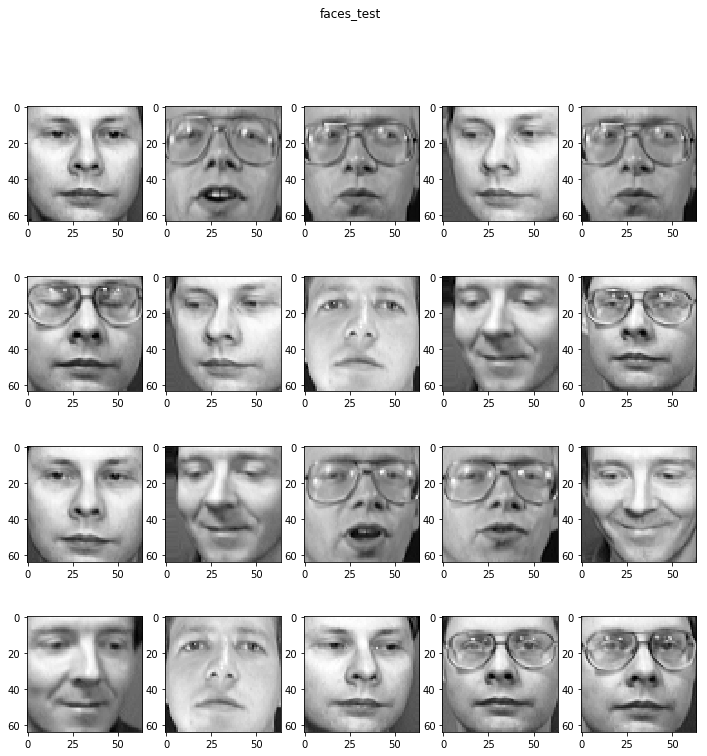

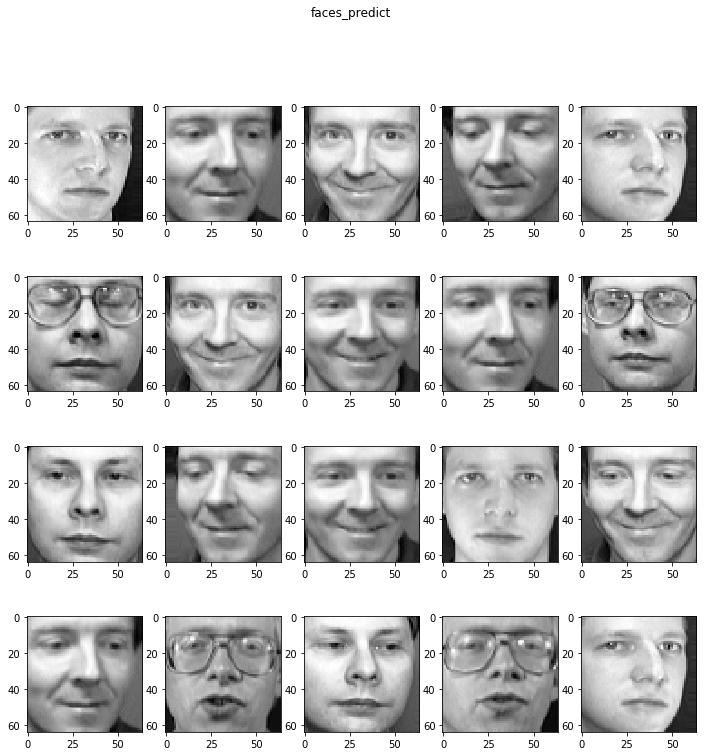

In [50]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_50 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_50)

In [51]:
list_pca_50_wrongList = wrong_detected(pipe_pred_test_50, 10, 120)

for wrongLocation in list_pca_50_wrongList:
    print('Using #{} where the label was {} predicted {}'.format(wrongLocation, y_test[wrongLocation], pipe_pred_test_50[wrongLocation]))

Wrongly detected image-locations: [0, 1, 2, 3, 4, 6, 7, 8, 12, 13, 16, 18, 19, 20, 21, 22, 23, 25, 28, 30, 33, 34, 37, 38, 39, 40, 41, 42, 44, 48, 49, 51, 52, 56, 59, 60, 61, 62, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 78, 79, 83, 84, 85, 88, 89, 91, 92, 99, 102, 105, 106, 107, 108, 109, 110, 111, 115, 117]
Total: 68
Using #0 where the label was 33 predicted 1
Using #1 where the label was 14 predicted 22
Using #2 where the label was 12 predicted 26
Using #3 where the label was 35 predicted 23
Using #4 where the label was 12 predicted 4
Using #6 where the label was 35 predicted 26
Using #7 where the label was 6 predicted 20
Using #8 where the label was 24 predicted 22
Using #12 where the label was 18 predicted 20
Using #13 where the label was 15 predicted 0
Using #16 where the label was 6 predicted 17
Using #18 where the label was 30 predicted 15
Using #19 where the label was 31 predicted 4
Using #20 where the label was 24 predicted 39
Using #21 where the label was 37 predicted 22
Using

#### Conclusion for PCA(50):
62 wrongly predicted images.

### <font color = 'red'> __4.4 Part 4: 'number of component' == 100: 0.90__</font>

### 4.4.1 Predict based on pipeline, and evaluate the model:

In [52]:
pipe_pred_test_100 = pipeline_RF_100.predict(X_test)
pipe_pred_prop_100 = pipeline_RF_100.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_100))

              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.33      0.50      0.40         2
           2       0.00      0.00      0.00         2
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         1
           5       0.33      0.67      0.44         3
           6       0.50      0.33      0.40         3
           7       1.00      0.67      0.80         3
           8       0.50      0.33      0.40         3
           9       1.00      0.33      0.50         3
          10       1.00      0.50      0.67         4
          11       1.00      0.50      0.67         6
          12       0.00      0.00      0.00         5
          13       1.00      1.00      1.00         1
          14       0.67      0.67      0.67         3
          15       0.67      0.40      0.50         5
          16       1.00      0.25      0.40         4
          17       0.00    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 4.4.2 Get the wrong prediction based on this model:

In [53]:
list_pca_100_wrongList = wrong_detected(pipe_pred_test_100, 10, 120)
print('\n')

for wrongLocation in list_pca_100_wrongList:
    print('Using #{} where the label was {} predicted {}'.format(wrongLocation, y_test[wrongLocation], pipe_pred_test_100[wrongLocation]))

Wrongly detected image-locations: [0, 1, 2, 3, 4, 6, 7, 8, 12, 13, 15, 16, 19, 20, 21, 22, 24, 25, 28, 29, 30, 34, 37, 38, 39, 40, 41, 42, 44, 48, 49, 51, 52, 56, 57, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 80, 83, 85, 88, 91, 98, 99, 102, 103, 105, 106, 107, 108, 109, 110, 111, 115, 117, 119]
Total: 72


Using #0 where the label was 33 predicted 1
Using #1 where the label was 14 predicted 25
Using #2 where the label was 12 predicted 39
Using #3 where the label was 35 predicted 23
Using #4 where the label was 12 predicted 39
Using #6 where the label was 35 predicted 20
Using #7 where the label was 6 predicted 19
Using #8 where the label was 24 predicted 22
Using #12 where the label was 18 predicted 3
Using #13 where the label was 15 predicted 0
Using #15 where the label was 22 predicted 4
Using #16 where the label was 6 predicted 38
Using #19 where the label was 31 predicted 17
Using #20 where the label was 24 predicted 5
Using #21 where the label was 37

- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 1,2,3,5,6,7 etc.are at error.
- <font color='red'>Total wrong prediction is 68.</font>

### 4.4.3 Pick some faces in test set & predicted set to check wrong prediction.

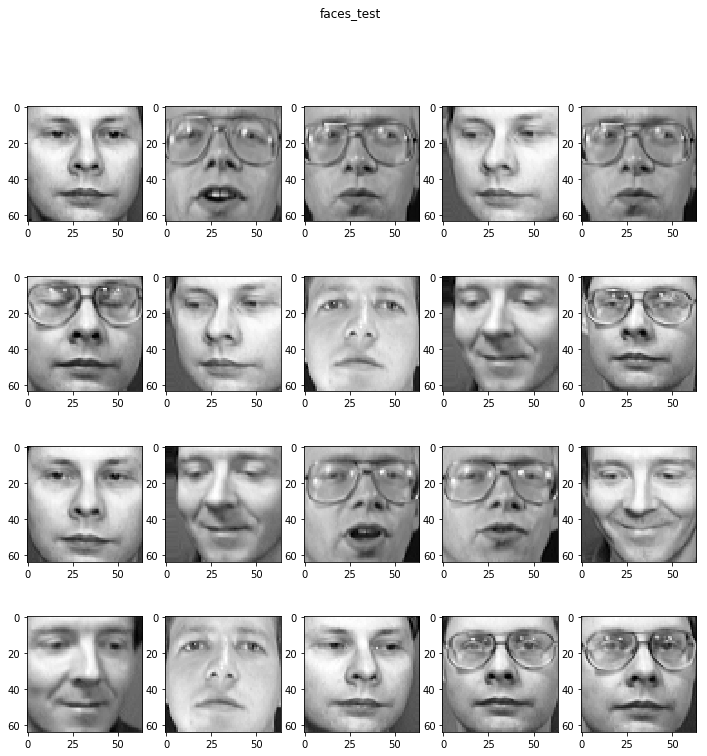

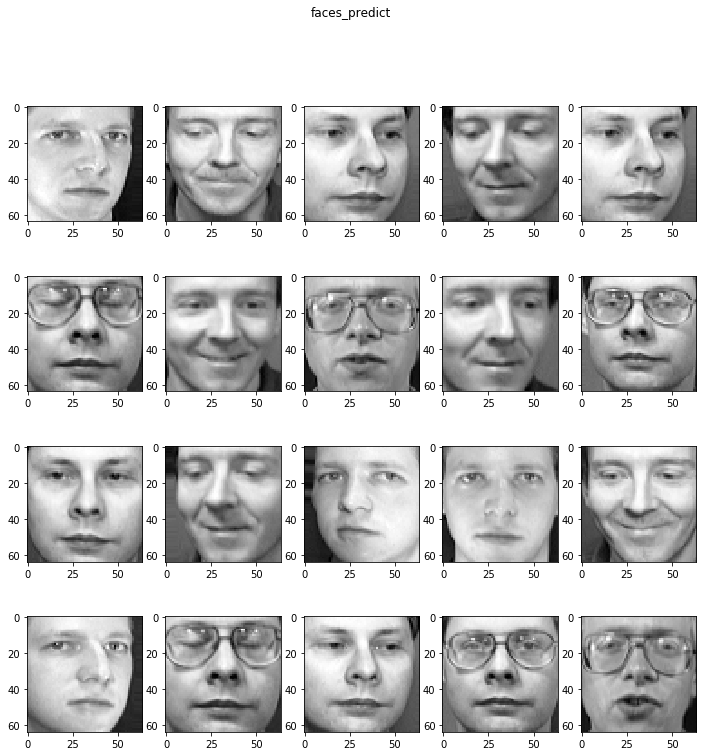

In [54]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_100 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_100)

#### Conclusion for PCA(100):
68 wrongly predicted images.

### <font color = 'red'> __4.5 Part 5: 'number of component' == 250: 0.95__</font>

### 4.5.1 Predict based on pipeline, and evaluate the model:

In [55]:
pipe_pred_test_250 = pipeline_RF_250.predict(X_test)
pipe_pred_prop_250 = pipeline_RF_250.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_250))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         2
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       1.00      1.00      1.00         3
           8       0.25      0.33      0.29         3
           9       1.00      0.33      0.50         3
          10       1.00      0.50      0.67         4
          11       0.50      0.33      0.40         6
          12       0.00      0.00      0.00         5
          13       1.00      1.00      1.00         1
          14       0.12      1.00      0.21         3
          15       1.00      0.60      0.75         5
          16       1.00      0.25      0.40         4
          17       0.00    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 4.5.2 Get the wrong prediction based on this model:

In [56]:
list_pca_250_wrongList = wrong_detected(pipe_pred_test_250, 10, 120)
print('\n')

for wrongLocation in list_pca_250_wrongList:
    print('Using #{} where the label was {} predicted {}'.format(wrongLocation, y_test[wrongLocation], pipe_pred_test_250[wrongLocation]))

Wrongly detected image-locations: [0, 2, 3, 4, 6, 7, 8, 11, 12, 13, 15, 16, 19, 21, 22, 23, 24, 25, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 48, 49, 51, 52, 56, 57, 59, 60, 61, 63, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 83, 84, 85, 88, 89, 90, 91, 92, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 119]
Total: 83


Using #0 where the label was 33 predicted 1
Using #2 where the label was 12 predicted 22
Using #3 where the label was 35 predicted 23
Using #4 where the label was 12 predicted 25
Using #6 where the label was 35 predicted 20
Using #7 where the label was 6 predicted 14
Using #8 where the label was 24 predicted 14
Using #11 where the label was 24 predicted 14
Using #12 where the label was 18 predicted 8
Using #13 where the label was 15 predicted 0
Using #15 where the label was 22 predicted 4
Using #16 where the label was 6 predicted 38
Using #19 where the label was 31 predicted 14
Using #21 where the label 

- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 0, 2, 3, 5, 6, 8, 9 etc.are at error.
- <font color='red'>Total wrong prediction is 83.</font>

### 4.5.3 Pick some faces in test set & predicted set to check wrong prediction.

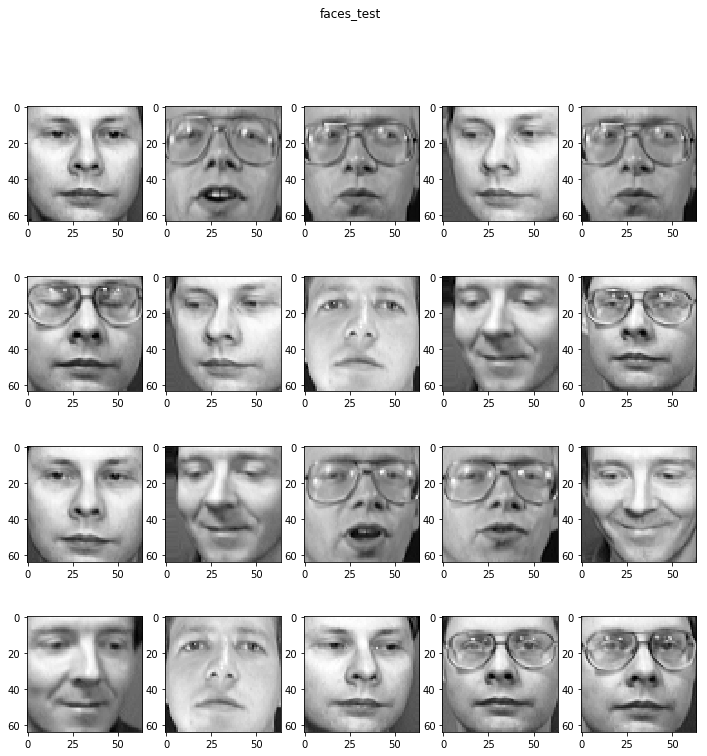

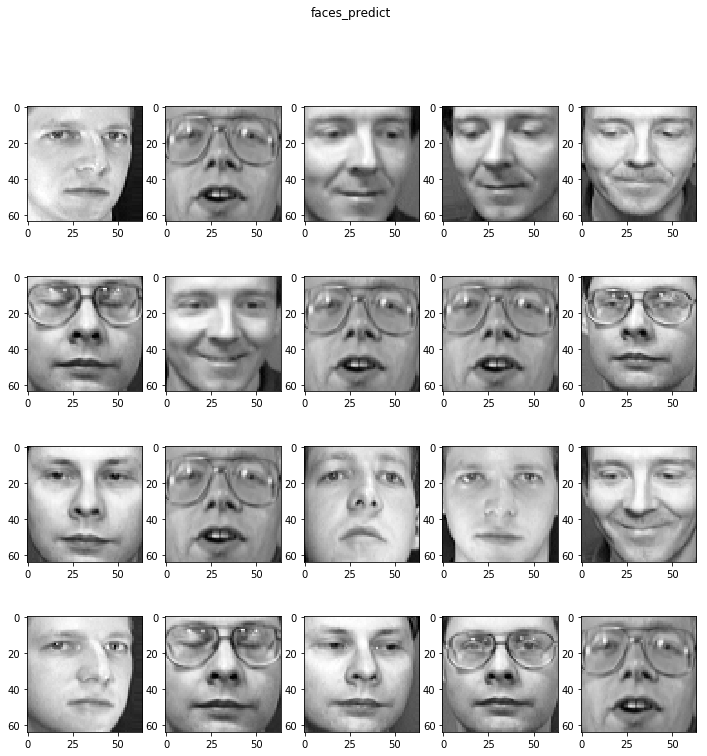

In [57]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_250 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_250)

#### Conclusion for PCA(250):
83 wrongly predicted images.

### <font color = 'red'> __4.6 Part 6: 'number of component' == 280: 0.99__</font>  

### 4.6.1 Predict based on pipeline, and evaluate the model:

In [58]:
pipe_pred_test_280 = pipeline_RF_280.predict(X_test)
pipe_pred_prop_280 = pipeline_RF_280.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_280))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       1.00      0.33      0.50         3
           7       1.00      1.00      1.00         3
           8       0.00      0.00      0.00         3
           9       1.00      0.33      0.50         3
          10       0.00      0.00      0.00         4
          11       0.33      0.17      0.22         6
          12       0.00      0.00      0.00         5
          13       1.00      1.00      1.00         1
          14       0.07      0.33      0.11         3
          15       0.67      0.40      0.50         5
          16       0.00      0.00      0.00         4
          17       0.00    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 4.6.2 Get the wrong prediction based on this model:

In [59]:
list_pca_280_wrongList = wrong_detected(pipe_pred_test_280, 10, 120)
print('\n')

for wrongLocation in list_pca_280_wrongList:
    print('Using #{} where the label was {} predicted {}'.format(wrongLocation, y_test[wrongLocation], pipe_pred_test_280[wrongLocation]))

Wrongly detected image-locations: [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 54, 56, 57, 59, 60, 61, 63, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 83, 84, 85, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 119]
Total: 95


Using #0 where the label was 33 predicted 4
Using #1 where the label was 14 predicted 4
Using #2 where the label was 12 predicted 18
Using #3 where the label was 35 predicted 18
Using #4 where the label was 12 predicted 18
Using #6 where the label was 35 predicted 20
Using #7 where the label was 6 predicted 18
Using #8 where the label was 24 predicted 18
Using #9 where the label was 32 predicted 18
Using #11 where the label was 24 predicted 4
Using #12 where the label was 18 predicted 4
Using #13 where the label was 15 predicted 8
Using #15 where the label w

- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 0, 2, 5, 6, 8, 9, 10, 12, 14, 17 etc.are at error.
- <font color='red'>Total wrong prediction is 81.</font>

### 4.6.3 Check the prediction and original images by location.

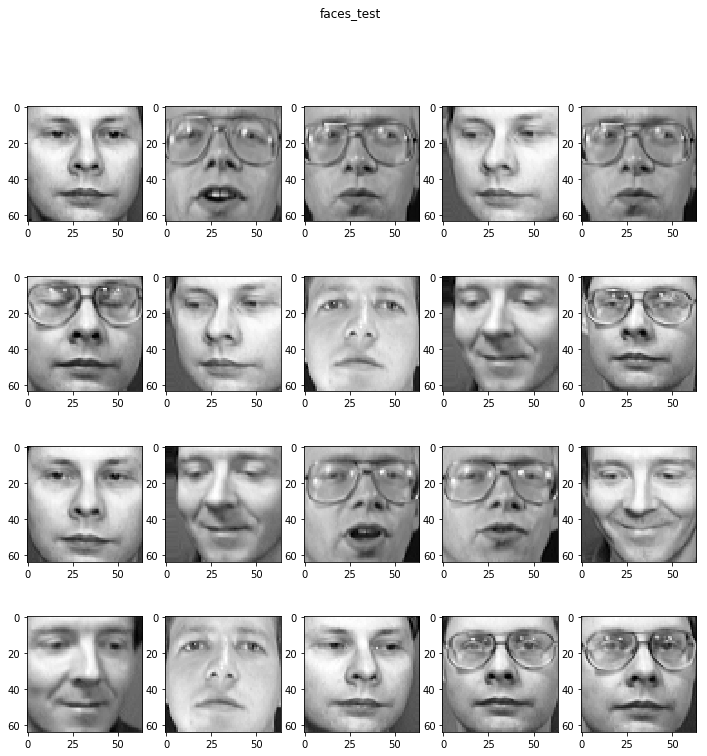

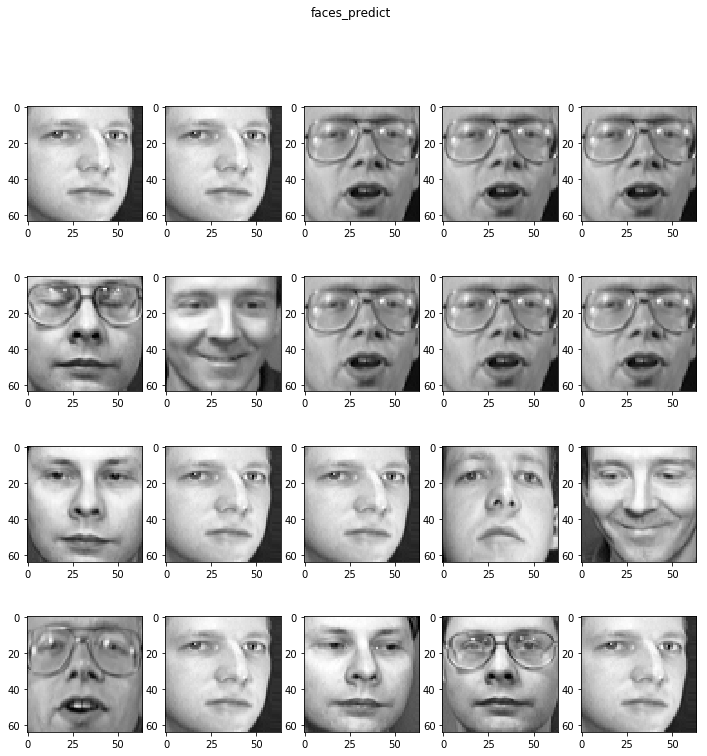

In [60]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_280 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_280)

#### Conclusion for PCA(280):
81 wrongly predicted images.

### 4.8 Store the PCA numbers and numbers of wrong prediction of every model.

- list_pca_wrong_prediction_count: (number of pca, number of wrong predictions)

In [61]:
list_pca_wrong_prediction_count

[(5, 83), (10, 58), (50, 68), (10, 68), (10, 72), (10, 83), (10, 95)]

- li_x_PCAcomponents: list of number of PCA components

In [62]:
li_x_PCAcomponents = [component for (component, num_wrong_predictions) in list_pca_wrong_prediction_count]
li_x_PCAcomponents

[5, 10, 50, 10, 10, 10, 10]

- li_y_num_correct_predictions: list of accurate prediction rate of every model.

In [63]:
li_y_num_correct_predictions = [(len(X_test)-num_wrong_predictions)/len(X_test) for (component, num_wrong_predictions) in list_pca_wrong_prediction_count]
li_y_num_correct_predictions

[0.30833333333333335,
 0.5166666666666667,
 0.43333333333333335,
 0.43333333333333335,
 0.4,
 0.30833333333333335,
 0.20833333333333334]

- Make a list to store (PCA_component_numbers, number of correct prediction)

In [64]:
list_pca_correct_prediction_count = list(zip(li_x_PCAcomponents, li_y_num_correct_predictions))
list_pca_correct_prediction_count

[(5, 0.30833333333333335),
 (10, 0.5166666666666667),
 (50, 0.43333333333333335),
 (10, 0.43333333333333335),
 (10, 0.4),
 (10, 0.30833333333333335),
 (10, 0.20833333333333334)]

### __4.9 Determine the optimum number of PCA components for accuracy-wall time trade-off:__ 
- The following chart will represent the relationship between 'number of components' and 'accuracy': The accuracy went down with the increasing of PCA components.

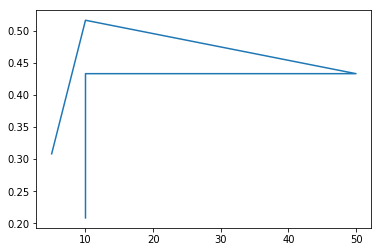

In [65]:
plt.plot(li_x_PCAcomponents, li_y_num_correct_predictions)

### 4.10 Determine the PCA benchmark with highest accuracy:

In [66]:
benchmark_id = max(list_pca_correct_prediction_count, key=lambda x:x[1])[0]
print('The best accuracy of PCA is with the number of component: ', benchmark_id)

The best accuracy of PCA is with the number of component:  10


Text(0.5, 0.98, '10-Component PCA')

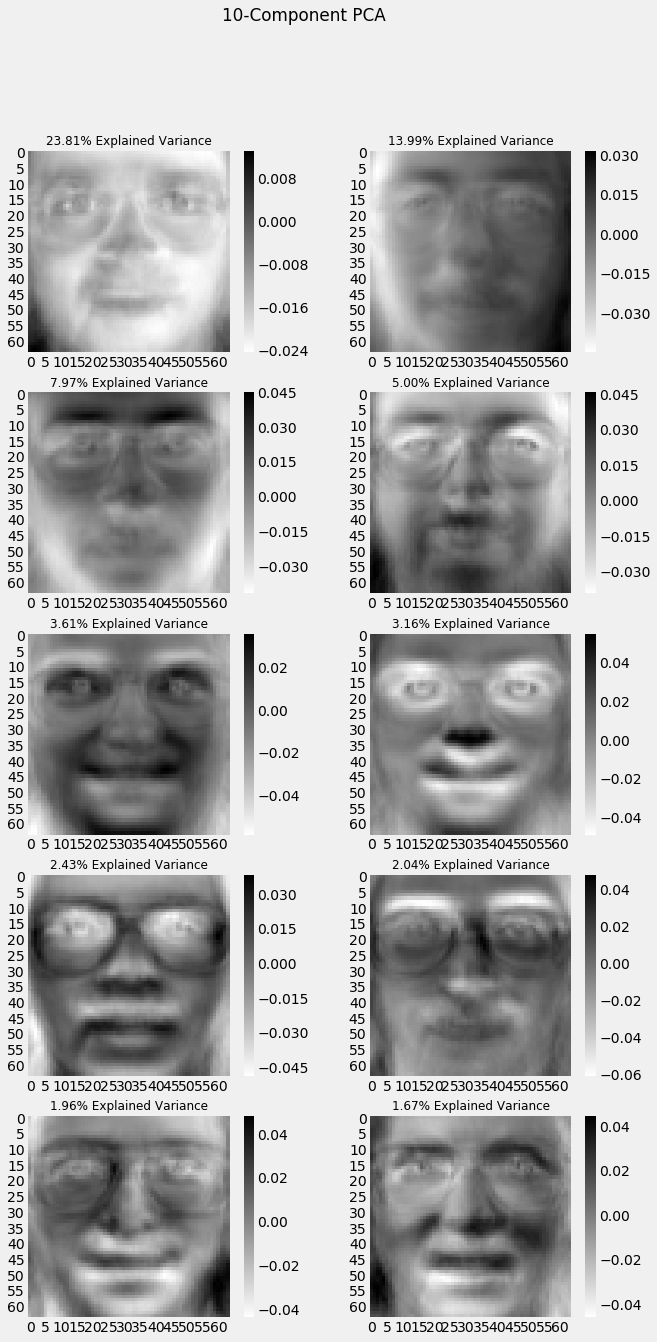

In [67]:
import seaborn as sns
plt.style.use('fivethirtyeight')
fig, axarr = plt.subplots(5, 2, figsize=(10, 20))

sns.heatmap(pca.components_[0, :].reshape(64, 64), ax=axarr[0][0], cmap='gray_r')
sns.heatmap(pca.components_[1, :].reshape(64, 64), ax=axarr[0][1], cmap='gray_r')
sns.heatmap(pca.components_[2, :].reshape(64, 64), ax=axarr[1][0], cmap='gray_r')
sns.heatmap(pca.components_[3, :].reshape(64, 64), ax=axarr[1][1], cmap='gray_r')
sns.heatmap(pca.components_[4, :].reshape(64, 64), ax=axarr[2][0], cmap='gray_r')
sns.heatmap(pca.components_[5, :].reshape(64, 64), ax=axarr[2][1], cmap='gray_r')
sns.heatmap(pca.components_[6, :].reshape(64, 64), ax=axarr[3][0], cmap='gray_r')
sns.heatmap(pca.components_[7, :].reshape(64, 64), ax=axarr[3][1], cmap='gray_r')
sns.heatmap(pca.components_[8, :].reshape(64, 64), ax=axarr[4][0], cmap='gray_r')
sns.heatmap(pca.components_[9, :].reshape(64, 64), ax=axarr[4][1], cmap='gray_r')

axarr[0][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100),
fontsize=12
)
axarr[0][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100),
fontsize=12
)
axarr[1][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100),
fontsize=12
)
axarr[1][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[3]*100),
fontsize=12
)
axarr[2][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[4]*100),
fontsize=12
)
axarr[2][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[5]*100),
fontsize=12
)
axarr[3][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[6]*100),
fontsize=12
)
axarr[3][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[7]*100),
fontsize=12
)
axarr[4][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[8]*100),
fontsize=12
)
axarr[4][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[9]*100),
fontsize=12
)


axarr[0][0].set_aspect('equal')
axarr[0][1].set_aspect('equal')
axarr[1][0].set_aspect('equal')
axarr[1][1].set_aspect('equal')
axarr[2][0].set_aspect('equal')
axarr[2][1].set_aspect('equal')
axarr[3][0].set_aspect('equal')
axarr[3][1].set_aspect('equal')
axarr[4][0].set_aspect('equal')
axarr[4][1].set_aspect('equal')

plt.suptitle('10-Component PCA')

## 5 Reconstruct the image with the optimum PCA.  
- In order to double check if this optimum PCA number could reconstruct the image clearly, we could inverse some image.  
- We would recover most of the essential characteristics of the data by this optimum components. To make this more concrete, we can compare the input images with the images reconstructed from these optimum components

In [68]:
def inverse_reconstruction_image(imageSet, person_id, dimensions_num, reshape_x, reshape_x_projected):
# Plot the results

    pca = PCA(dimensions_num).fit(imageSet)
    print('The number of PCA components is: ', dimensions_num)
    components = pca.transform(imageSet)
    projected = pca.inverse_transform(components)

    fig, ax = plt.subplots(2, 10, figsize=(10, 3),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i in range(10):
        ax[0, i].imshow(imageSet[i+10*(int(person_id)-1)].reshape(reshape_x, -1), cmap='binary_r')
        ax[1, i].imshow(projected[i+10*(int(person_id)-1)].reshape(reshape_x, -1), cmap='binary_r')
    
    ax[0, 0].set_ylabel('full-dim\ninput')
    ax[1, 0].set_ylabel(str(dimensions_num) +'-dim\nreconstruction');

The number of PCA components is:  10


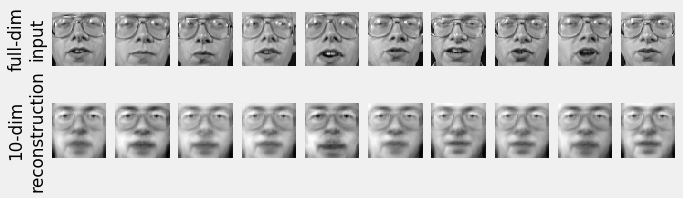

In [69]:
# This is inversion by PCA(10)-Benchmark. Variance: 0.7. Accurate prediction: 66 images.
inverse_reconstruction_image(faces.data, 2, 10, 64, 64)

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 10 of the ~4096 initial features. This visualization makes clear why the PCA feature selection used in In-Depth: Support Vector Machines was so successful: although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image. What this means is that our classification algorithm needs to be trained on 10-dimensional data rather than 4096-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

### Conclustion:
<font color='red' >When PCA components=10, the accuracy is the peak. Thus, we could choose PCA(10) for model.</font>
- It is not always correct that the accuracy will go up along with the increasing PCA components.

## 6 Interpret the wrong prediction in non-benchmark model:

- Since we got the PCA component=10 is the best trade-off for accuracy & wall time,  <font color='red'>the model(Part 2: 'number of component' == 10) as below will be the benchmark for interpretation. </font>
  - pipeline_RF_10 = Pipeline([('Turn Gray',step_turnGray),('Flatten images', step_flatten),('Normalize', Normalizer()),
  ('PCA', PCA(10)), # # project from 4096 to 10 dimensions
  ('XGBoost_Model', GradientBoostingClassifier())])

### 6.0. Introduction to model interpretability-LIME:  

#### Why Interpretability and LIME?
'AI not just to learn but also to teach. Features that are globally important may not be important in the local context, and vice versa. While global fidelity would imply local fidelity, identifying globally faithful explanations that are interpretable remains a challenge for complex models.'  
                    — Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin'
<img src = 'Image/pros.png'>                   
- __<font color='red'>We want to incorporate the explanation & justification in a human-AI interaction</font> by:__
    - Figure out which segments will represent the top features explaining the classification of the image as containing a specific object (like tennis/basketball etc.)?  
    - Comparing models will be more than based on their accuracy, but also based on their justifications given a “ground truth” justification set
    - <font color='red'>In turn, a way for integrating people into general decision making:   
        - Using human annotations of the actual object as justification was able to slightly (yet significantly) improve the Learner’s performance when there where little or biased images to learn from. Results in fine tuning hyper-parameters such as the number of image segments to include in an explanation</font>
    <img src = 'Image/EX3.png'>
    
#### What is LIME?  
- LIME (Local Interpretable Model Explainer) intends to explain a decision made by classification model. This can either be a decision tree, random forest or even a neural network. LIME is to find a “simple” approximation which helps to “explain” how the complex model “behaves” at that certain point.
    - For example when you have a neural network that predicts a label for an image you can explain its functionality by LIME.
- LIME output as an local explanation we took for the current classifier and its explanation as givens (and only asked ourself “should we trust this classifier?”, as the LIME article suggests)

    
#### How LIME works?
- __Assumption__:
    - by relying on the assumption that every complex model is linear on a local scale. 
    
- __Theory__:  
   - Formally, we need a weight function wʸ: X→ℝ⁺ that gives the most weight to the instances z∈X closest to the instance we want to explain y∈ X and the least weight to the instances that are furthest away.  
    
- __Practice__:  
   - LIME produces explanations in the form of image segments.  
   - We create a new explainer for our image classifier. Then we let it explain the classification for a specific image. This produces an explanation object that we can visualize.
    - For illustration by following charts: While the focus of the LIME is the user’s trust of the model’s classification (indicated in a red circle in the first casual model), and accordingly it uses the user’s agreement with the model’s explanation as a surrogate for this measure of trust;   
    - The focus of the later is on using this level of agreement to actually influence the model, and to generate a better one (indicated in a red arrow in the second casual model).
<img src = 'Image/LIME-cause.png'>

- __Steps:__  
    - It uses the classifier (pretrained model) to classify this variant.  
    - Having the classification for each of these variants (and their distance from the original image)  
    - The previous step enables LIME to, finally, create an optimal linear model of the “importance” of each image segment to the eventual class. (by explain_instance method)
    - After generating it, we can ask for the “top segment” or “top X segments” which explains the classification of this image as a targeted object (corresponding to the highest coefficient in our linear model).
    - Or, we can also ask for the top “pros” (positive coefficients) and cons (negative coefficients) for classifying this image as the targeted object(or any other class for that matter).
<img src = 'Image/lime.png'>

#### Pros of LIME:
- LIME treats the classifying model as a “black box”, and thus does not depend at all on the architecture of the original classifier (this is LIME’s Model-Agnostic attribute). This is a really cool feature that enables to get an “explanation” for any classifier.  
- The current LIME library was designed to work with:
    - Tensorflow;
    - Keras;
    - integrate it with PyTorch – namely converting some variables to Tensors

#### Challenges of LIME:
- Computationally heavy: The original LIME tutorial cites 7.65 minutes for generating an explanation for a given image.  
- “bottle neck” of the process: was generating and classifying 1000 variants of the original image.  
- it is quite hard to find a non-qualitative measure for how “good” an explanation is.
<img src = 'Image/LIME_cons.png'>  

#### Further action:
- Improve the efficiency by :  
    - Combining with take advantage of GPU PyTorch.  
    - Utilize more segmentation algorithms for less granular images (And check the accuracy)

- ??? How could we conduct multiple explanations for classifying the same image?
     - Thought: It would probably also be a good idea to cache the image segmentation outcome altogether.

### 6.1 Check the overlapping wrong predictions by other non-benchmark models.

In [70]:
def getIntersectionOfWrongPredictions_non_benchmark(list_pca_number_wrongPredictionLocation):
    list_temp = [item[1] for item in list_pca_number_wrongPredictionLocation if item[0]!=benchmark_id]
    list_pca_wrongPrediction_intersection = set(list_temp[0]).intersection(*list_temp)
    
    print(list_pca_wrongPrediction_intersection, end=' ')
    return list_pca_wrongPrediction_intersection

In [71]:
list_pca_wrongPrediction_intersection = getIntersectionOfWrongPredictions_non_benchmark(list_pca_number_wrongPredictionLocation)


{0, 1, 2, 3, 4, 6, 7, 8, 13, 16, 18, 19, 20, 21, 23, 30, 33, 34, 37, 38, 39, 41, 42, 44, 48, 49, 52, 56, 59, 60, 61, 65, 67, 68, 69, 72, 74, 75, 78, 79, 83, 84, 85, 88, 89, 91, 92, 99, 102, 105, 106, 107, 108, 109, 111, 115} 

- The images with postion of 3, 4, 5, 7, 9, 12, 13 etc. are the wrong predictions in non-benchmark models

### 6.2 Interpret these overlapping wrong predictions with LIME:

### 6.2.0 Goal:  
   - Figure out “should we trust this classifier?”, as the LIME article suggests
   - Find an explanation for a classification the algorithm got wrong.
   - Figure out what the important areas caused these failures by interpretability.

### 6.2.1: Define function to plot:

__explanation.get_image_and_mask()__:
    https://lime-ml.readthedocs.io/en/latest/lime.html  
- label – label to explain  
- positive_only – if True, only take superpixels that contribute to the prediction of the label. Otherwise, use the top  
- num_features superpixels, which can be positive or negative towards the label  
- hide_rest – if True, make the non-explanation part of the return image gray  
- num_features – number of superpixels to include in explanation

In [72]:
def plotExplanationWithMask(explanation, pipeline_name, testImage, image_location, positive_num_features, posNeg_num_features, if_hide_rest):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    fig.suptitle('{}'.format(pipeline_name), fontsize=10, fontweight='bold')

    temp, mask = explanation.get_image_and_mask(testImage[image_location], positive_only=True, num_features=positive_num_features, hide_rest = if_hide_rest)
    
    ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax1.set_title('Positive Regions for {}'.format(testImage[image_location]))
    
    temp, mask = explanation.get_image_and_mask(testImage[image_location], positive_only=False, num_features=posNeg_num_features, hide_rest = if_hide_rest)
    
    ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax2.set_title('Positive/Negative Regions for {}'.format(testImage[image_location]))    
    
    dirName = 'Output/'+str(image_location)+'/'
    
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory: " , dirName ,  " Created ")
    else:    
        print("Directory: " , dirName ,  " already exists")
    
    save_image_path = dirName+str(image_location)+'_'+pipeline_name+'.jpg'
    plt.savefig(save_image_path)
    
    print(str(image_location)+'_'+pipeline_name+' has been saved under '+dirName)
    

In [73]:
def saveImage(fig, pipeline_name, image_location):
    save_image_path = 'Output/'+str(image_location)+'/'+str(image_location)+'_'+pipeline_name+'.jpg'
    plt.savefig(save_image_path)
    
    plt.close(fig)

### 6.2.2 Get all wrong predictions shared by all pipelines. 

In [74]:
np.array(list_pca_wrongPrediction_intersection)

array({0, 1, 2, 3, 4, 6, 7, 8, 13, 16, 18, 19, 20, 21, 23, 30, 33, 34, 37, 38, 39, 41, 42, 44, 48, 49, 52, 56, 59, 60, 61, 65, 67, 68, 69, 72, 74, 75, 78, 79, 83, 84, 85, 88, 89, 91, 92, 99, 102, 105, 106, 107, 108, 109, 111, 115},
      dtype=object)

- Randomly pick one of wrong predictions from the intersection for futher interpretability: 

In [75]:
error_location = random.choice(list(list_pca_wrongPrediction_intersection))
error_location

6

### 6.2.3 Explain the pipelines with different PCA components on some wrong prediction.

In [76]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
from lime import lime_image

- __Segmentation for LIME interpretability:__  
    - Diverse segmentation for passing in LIME:  
        - Quickshift, SLIC, Felzenszwalbs's method etc., the corresponding segmentation will be different:  
        <img src='Image/seg.PNG'>
    - __SLIC( Simple Linear Iterative Clustering)__: 
        - In this case, SLIC was utilized for LIME.
        - Uses a machine learning algorithm called K-Means(Unsupervised segmentation) under the hood.  
        - It takes in all the pixel values of the image and tries to separate them out into the given number of sub-regions. (In this case, reduced this image from 64*64 pixels/image down to 100 regions.)

In [77]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

- We will get two images interpreted:  
    - which display the areas which have contributed positively towards the prediction by red, and  
    - the features which have negatively contributed by purple

Directory:  Output/6/  Created 
6_pipeline_RF_5 has been saved under Output/6/
Directory:  Output/6/  already exists
6_pipeline_RF_10 has been saved under Output/6/
Directory:  Output/6/  already exists
6_pipeline_RF_50 has been saved under Output/6/
Directory:  Output/6/  already exists
6_pipeline_RF_100 has been saved under Output/6/
Directory:  Output/6/  already exists
6_pipeline_RF_250 has been saved under Output/6/
Directory:  Output/6/  already exists
6_pipeline_RF_280 has been saved under Output/6/


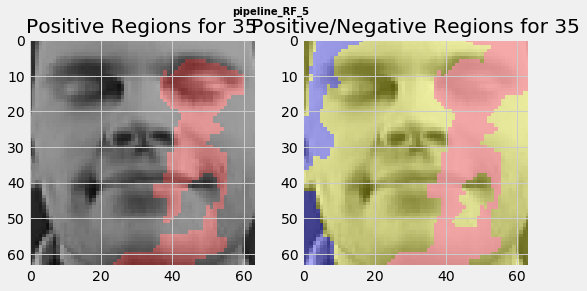

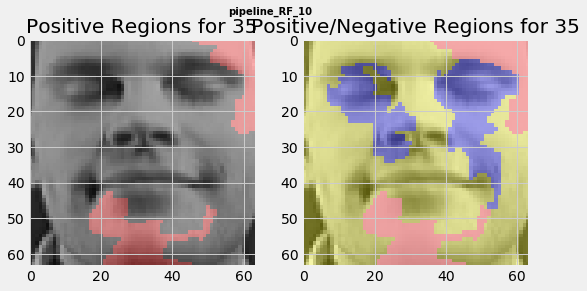

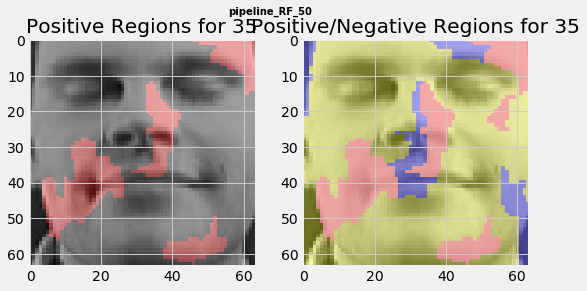

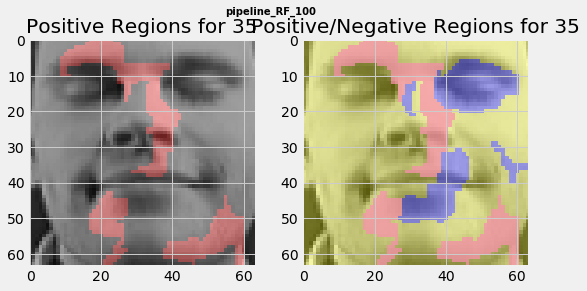

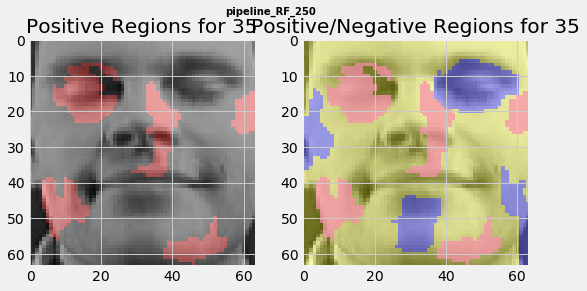

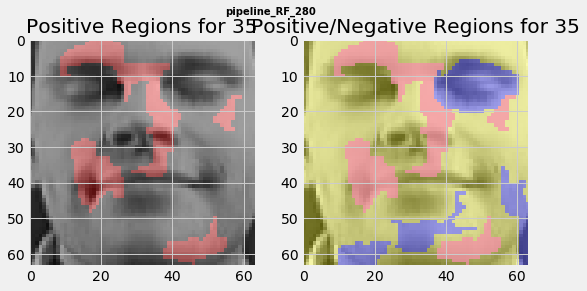

In [78]:
for (pipeline_name, pipeline) in list_pipeline_RF:
    #print(pipeline_name)
    explanation_proba = explainer.explain_instance(X_test[error_location], 
                                         classifier_fn = pipeline.predict_proba, 
                                         top_labels=50, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
    plotExplanationWithMask(explanation_proba, pipeline_name, y_test, error_location, 5, 10, False)

### Extra Experiments on granular of segmentation:  
- n_segments = 30
- n_segments = 50
- n_segments = 70


#### n_segments = 30:  

In [86]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=30, compactness=1, sigma=1)

Directory:  Output/34/  already exists
34_pipeline_RF_5 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_10 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_50 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_100 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_250 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_280 has been saved under Output/34/


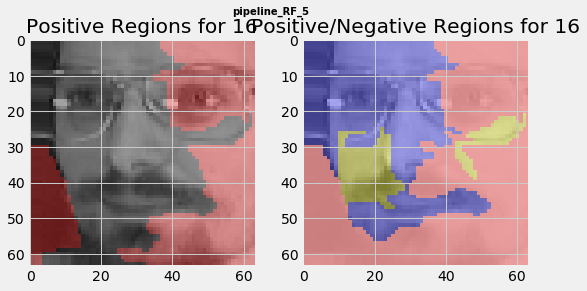

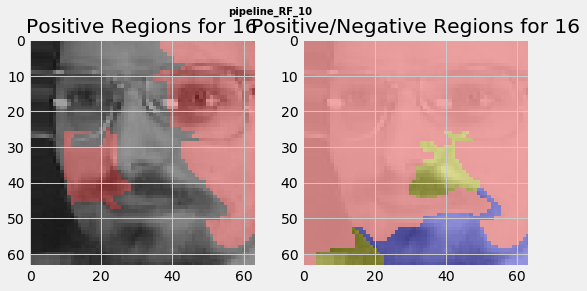

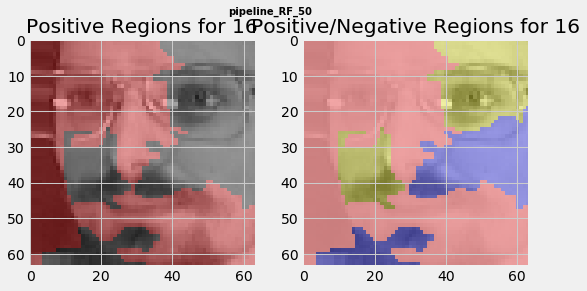

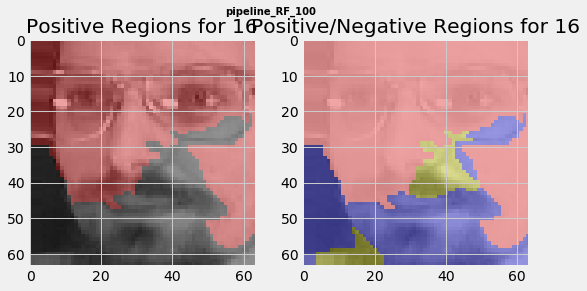

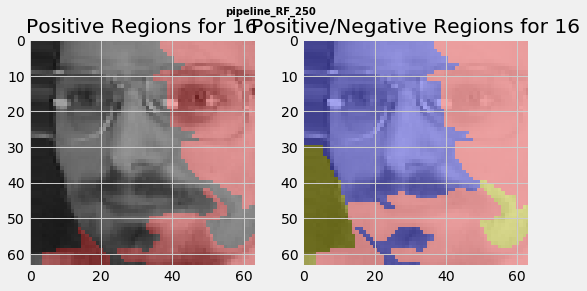

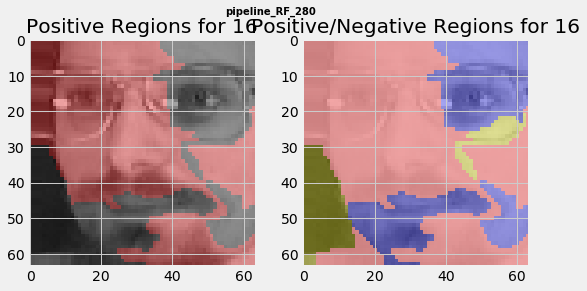

In [87]:
for (pipeline_name, pipeline) in list_pipeline_RF:
    #print(pipeline_name)
    explanation_proba = explainer.explain_instance(X_test[error_location], 
                                         classifier_fn = pipeline.predict_proba, 
                                         top_labels=50, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
    plotExplanationWithMask(explanation_proba, pipeline_name, y_test, error_location, 5, 10, False)

#### n_segments = 50

In [88]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=50, compactness=1, sigma=1)

Directory:  Output/34/  already exists
34_pipeline_RF_5 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_10 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_50 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_100 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_250 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_280 has been saved under Output/34/


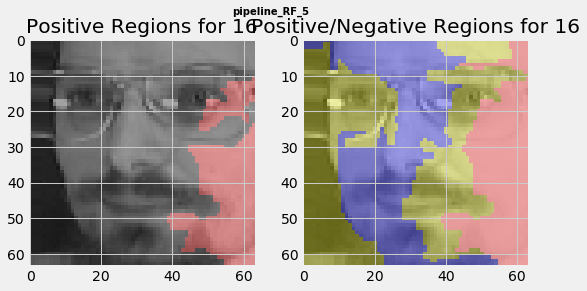

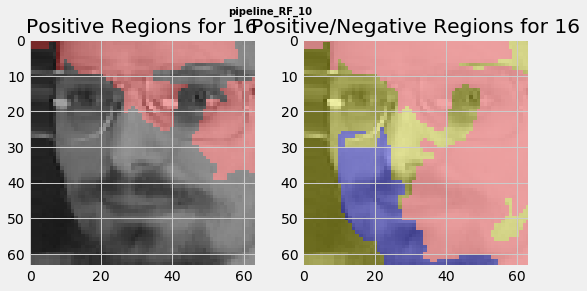

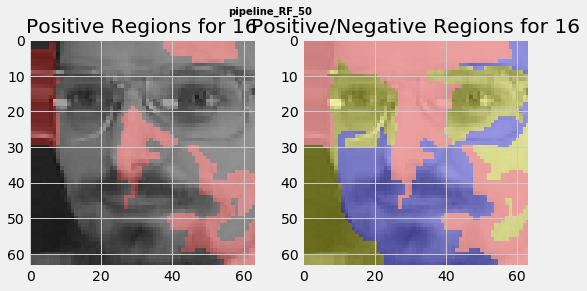

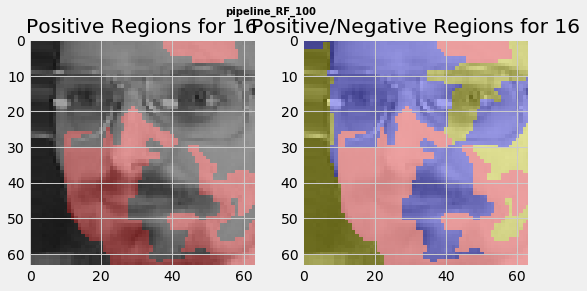

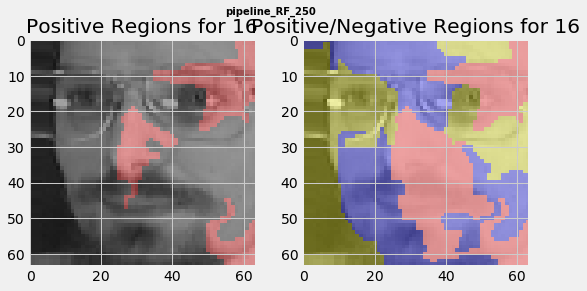

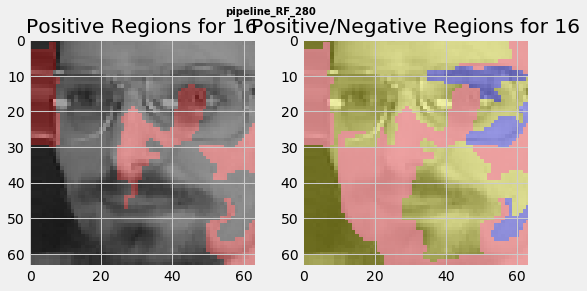

In [89]:
for (pipeline_name, pipeline) in list_pipeline_RF:
    #print(pipeline_name)
    explanation_proba = explainer.explain_instance(X_test[error_location], 
                                         classifier_fn = pipeline.predict_proba, 
                                         top_labels=50, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
    plotExplanationWithMask(explanation_proba, pipeline_name, y_test, error_location, 5, 10, False)

#### Some parameters in explainer.explain_instance():
   - top_labels – if not None, ignore labels and produce explanations for the K labels with highest prediction probabilities, where K is this parameter.  
   - num_samples – size of the neighborhood to learn the linear model.

In [79]:
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_5[error_location]))
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_10[error_location]))
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_50[error_location]))
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_100[error_location]))
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_250[error_location]))
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_280[error_location]))

Using #6 where the label was 35 predicted 6
Using #6 where the label was 35 predicted 6
Using #6 where the label was 35 predicted 26
Using #6 where the label was 35 predicted 20
Using #6 where the label was 35 predicted 20
Using #6 where the label was 35 predicted 20


#### Conclusion:  
- It is found some areas are interpreted differently by comparing with PCA(10) benchmark by following chart. (Green: Same with benchmark; Red: Different)
<img src='Output/34/34_B_Compare.png'>
- Other alternative better substitute: P(5)

#### Tuning guidance: How could we tune the hyperparameters for improving features?  

Because al the models were intrepred on the shared error predictions, we just need to tune the hyperparemeters with the opposite operations.  
- There are 3 parts (Left eye, right eye, chin) are interpreted by model-PCA(10) XGB model. Thus,  
    - <font color='red'>We could benefit from augmenting other parts by tuning hyperparameters of this model.</font>
- Other XGB models: PCA(5), PCA(100), PCA(250) have the same errors in 'Positive Nose'. Thus,
    - <font color='red'>We could degrade the importance of nose on benchmark model PCA(10) by tuning to make it more negative.</font>
- Other XGB models: PCA(100), PCA(280) have the same errors in 'Postive Right cheek'. Thus,  
    - <font color='red'>We could degrade the importance of 'Right cheek' on benchmark model PCA(10) by tuning to make it more negative.</font>
- We have 3 wrong highlight points on 'Positive Nose' in other non-benchmark models(PCA(5), PCA(100), PCA(250)). It is likely the PCA(10) benchmark model neglect the importance of 'Nose'. Thus,  
    - <font color='red'>We could benefit from augmenting the importance of 'Right Eye' by tuning hyperparameters, and then degrade the importance of 'Right Eye' on benchmark model PCA(10) by tuning to make it more negative. </font>

### 6.2.4 Interpret another wrong prediction:  

- Randomly pick another wrong prediction from intersection of wrong prediction:

In [80]:
error_location = random.choice(list(list_pca_wrongPrediction_intersection))
error_location

34

Directory:  Output/34/  already exists
34_pipeline_RF_5 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_10 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_50 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_100 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_250 has been saved under Output/34/
Directory:  Output/34/  already exists
34_pipeline_RF_280 has been saved under Output/34/


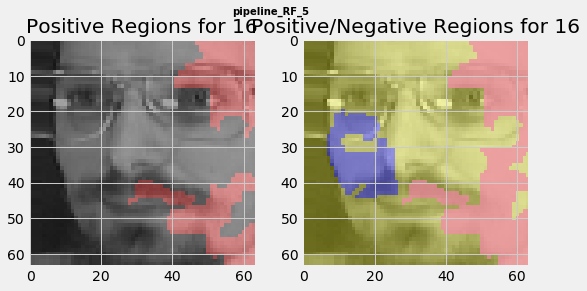

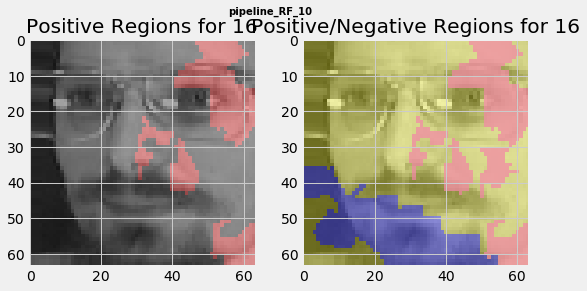

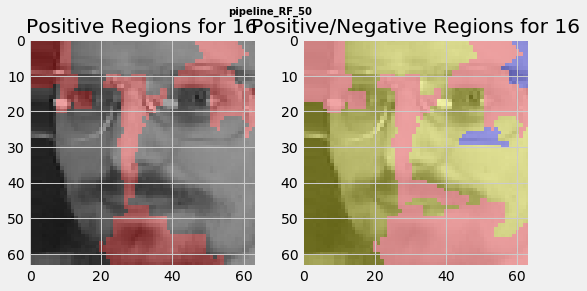

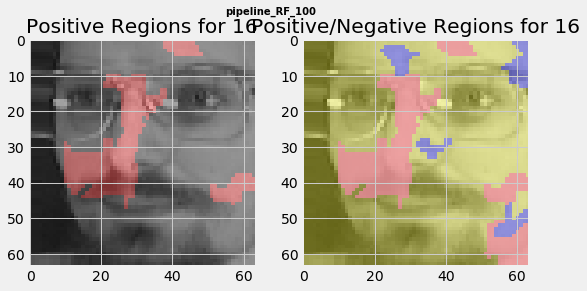

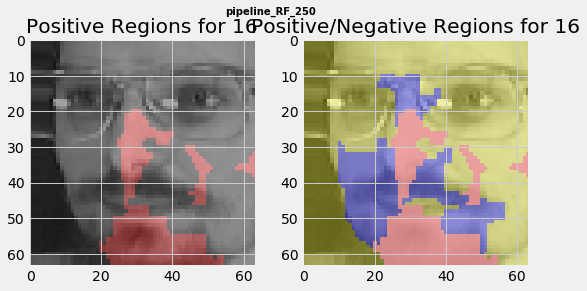

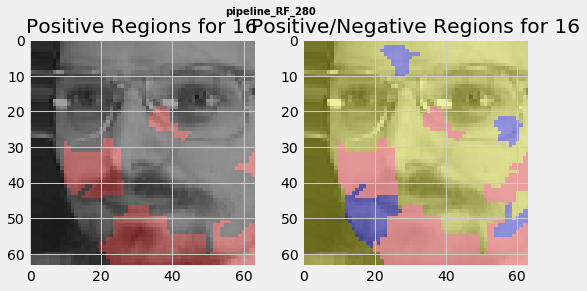

In [81]:
for (pipeline_name, pipeline) in list_pipeline_RF:
    #print(pipeline_name)
    explanation_proba = explainer.explain_instance(X_test[error_location], 
                                         classifier_fn = pipeline.predict_proba, 
                                         top_labels=50, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
    plotExplanationWithMask(explanation_proba, pipeline_name, y_test, error_location, 5, 10, False)
    
    #saveImage(fig, pipeline_name, error_location)

In [82]:
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_5[error_location]))
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_10[error_location]))
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_50[error_location]))
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_100[error_location]))
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_250[error_location]))
print('Using #{} where the label was {} predicted {}'.format(error_location, y_test[error_location], pipe_pred_test_280[error_location]))

Using #34 where the label was 16 predicted 30
Using #34 where the label was 16 predicted 16
Using #34 where the label was 16 predicted 5
Using #34 where the label was 16 predicted 26
Using #34 where the label was 16 predicted 5
Using #34 where the label was 16 predicted 5


#### Conclusion:  
- It is found some areas are interpreted differently by comparing with PCA(10) benchmark by following chart. (Green: Same with benchmark; Red: Different)
<img src='Output/44/44_B_Compare.png'>
- Another models(PCA(100), PCA(280)) could be the substitute of benchmark model.  

#### Tuning guidance: How could we tune the hyperparameters for improving features?   
Because al the models were intrepred on the shared error predictions, we just need to tune the hyperparemeters with the opposite operations.  

- There are only 4 parts (Negative Left eye, Positive nose, Positive Mouth, Negative Right Cheek) are interpreted by model-PCA(10) XGB model. Thus,  
    - <font color='red'>We could benefit from augmenting other parts(Right eye, Left cheek, Forehead, Chin) by tuning hyperparameters of this model.</font>
- Other XGB models: PCA(5), PCA(100), PCA(280) have the same wrong attitute result in 'Right Cheek' compared with benchmark model. Thus,
    - <font color='red'>We could degrade the importance of 'Right Cheek' by tuning hyperparameters to correct them to be more Negative.</font>
- Other XGB models: We have 5 models(PCA(5), PCA(10), PCA(100), PCA(250), PCA(280)) have the shared wrong attitude on 'Positive Mouth'. Thus,  
    - <font color='red'>Correct the hyperparameters on benchmark PCA(10) for degrading the positiveness of mouth.</font>
- We had wrong attitude results of 'Left eye' compared with benchmark. Thus,  
    - <font color='red'>We could degrade the importance of 'Left eye' by tuning to make it more 'negative'.</font>
- We have 4 'Positive Right Eye' in other non-benchmark models. It is likely the PCA(10) benchmark model neglect the importance of 'Right Eye'. Thus,  
    - <font color='red'>We could benefit from augmenting the importance of 'Right Eye' by tuning hyperparameters. And then degrade for making the 'Right eye' to be more negative. </font>  
- 4 'Positive Right Cheek' in benchmark and non-benchmark models(PCA(5), PCA(10), PCA(100), PCA(280)). It is likely the PCA(10) benchmark model over-estimated the 'Right Cheek' as Negative. Thus,  
    - <font color='red'>We could benefit from augmenting the positiveness of 'Right Cheek' by tuning hyperparameters. </font>

## 7 Wrapping up:  
- It is not always correct that PCA works better with increasing of PCA components, and different PCA principal vectors seem to be picking out certain features differently, such as eyes, noses, and lips.
- LIME image interpretability will help to understand how the models perform differently or why the model failed.

## 8 Further step:
 This work focused on XGM model, and combine with different PCA component for image classification and interpretability. Even though XGM may not perform better than other models, like SVM. Thus, the further steps will be:
- __Model__:  
    Further I will explore how different PCA and interpretability work on the other models, like SVM on this face dataset. And explore the optimum combination of PCA components number and model for better image reconstruction.  
- __Interpretability__:  
    More work on identify: “small justification” or the “most convincing” justification: we can even generate a list of “justifications” by a classifier by passing it random crops of the original image and caching those which are sufficient for it to classify the image the way it does. 
- __Interaction__:  
    Tune the hyperparameters with the guidance of interpretability for better precision according to “small justification” or the “most convincing” justification.
- __GPU__:  
    Explore if programming model for NVIDIA GPUs could help on speeding up.
- __Interesting__: 
    PCA(10) has higher precision than PCA(100), PCA(250), PCA(280)...
<img src='Image/PCA_precision.png'>


## Reference:  
- Image Segmentation using Python’s scikit-image module: https://towardsdatascience.com/image-segmentation-using-pythons-scikit-image-module-533a61ecc980  
- In Depth: Principal Component Analysis: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html  
- In-Depth: Support Vector Machines: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html  
- From Zero to Hero in XGBoost Tuning https://towardsdatascience.com/from-zero-to-hero-in-xgboost-tuning-e48b59bfaf58  
- Image recognition https://mclguide.readthedocs.io/en/latest/sklearn/image.html  
- https://www.braincreators.com/2018/08/from-lime-explanations-to-justifications-part-2-3/
- The Ultimate Guide to 12 Dimensionality Reduction Techniques https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/  
- Comparison of segmentation and superpixel algorithms https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html?highlight=superpixel

## Appendix:

c:\python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


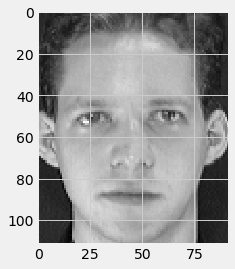

In [83]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
img = imread('data/att_faces/s1/1.pgm')
img = img.astype(np.uint8)
img = img / 255
plt.imshow(img,cmap='gray')